In [1]:
import numpy as np
import pandas as pd
import pickle
pd.options.mode.chained_assignment = None
from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.decomposition import PCA

Loading data from csv

In [2]:
cars_fc = pd.read_csv('model_input.csv')
cars_fc_target = cars_fc.loc[:, ['mixed_fuel_consumption_per_100_km_l']]
cars_fc_data = cars_fc.drop(['mixed_fuel_consumption_per_100_km_l'], axis='columns')

Split to train and test data

In [3]:
data_train, data_test, target_train, target_test = train_test_split(cars_fc_data, cars_fc_target, test_size=0.2)

## Regression models

In [4]:
def analyze(x_train, x_test, y_train, y_test, reg):

    reg.fit(x_train, y_train)
    y_pred = reg.predict(x_test)
    
    y_test = y_test.to_numpy().flatten()
    
    print(np.mean(y_pred))
    print(f"Absolute error: {metrics.mean_absolute_error(y_test, y_pred)}")
    print(f"Squared error: {metrics.mean_squared_error(y_test, y_pred)}")
    print(f"Max error: {metrics.max_error(y_test, y_pred)}")
    
    return y_test, y_pred

def cross_validation(data, target, reg):
    kf = KFold(n_splits=5, shuffle=True, random_state=23)
    return cross_validate(reg, data, target, scoring='neg_mean_squared_error', cv=kf)

Linear regression

In [5]:
std = StandardScaler()
data_train_t = std.fit_transform(data_train)
data_test_t = std.transform(data_test)

reg = LinearRegression()

# analyze(data_train_t, data_test_t, target_train, target_test, reg)
cv = cross_validation(data_train_t, target_train, reg)
cv
# np.average(cv['test_score'])

{'fit_time': array([0.02251697, 0.00300121, 0.00399923, 0.00201488, 0.00400209]),
 'score_time': array([0.00201249, 0.00099826, 0.00100327, 0.00098276, 0.        ]),
 'test_score': array([-2.80310795, -2.72106517, -2.74208955, -2.66659053, -2.34170307])}

Polynomial regression

In [6]:
std = StandardScaler()
data_train_t = std.fit_transform(data_train)
data_test_t = std.transform(data_test)

pol = PolynomialFeatures()
data_train_t = pol.fit_transform(data_train_t)
data_test_t = pol.transform(data_test_t)

reg = LinearRegression()

# analyze(data_train_t, data_test_t, target_train, target_test, reg)
cv = cross_validation(data_train_t, target_train, reg)
cv
# np.average(cv['test_score'])

{'fit_time': array([0.21802735, 0.15766978, 0.09534597, 0.13133836, 0.14868212]),
 'score_time': array([0.00199914, 0.00099802, 0.00099874, 0.0009954 , 0.00199771]),
 'test_score': array([-1.65166219e+13, -1.00586445e+16, -1.84857173e+19, -1.45785216e+18,
        -1.97655172e+18])}

Polynomial regression with regularization

In [7]:
def poly_reg_t(data_tr, data_te): 
    std = StandardScaler()
    data_tr_t = std.fit_transform(data_tr)
    data_te_t = std.transform(data_te)
    
    pol = PolynomialFeatures()
    data_tr_t = pol.fit_transform(data_tr_t)
    data_te_t = pol.transform(data_te_t)
    
    return data_tr_t, data_te_t

In [8]:
data_train_t, data_test_t = poly_reg_t(data_train, data_test)

reg = ElasticNet(alpha=0.1, max_iter=20000)

# analyze(data_train_t, data_test_t, target_train, target_test, reg)
cv = cross_validation(data_train_t, target_train, reg)
cv
# np.average(cv['test_score'])

{'fit_time': array([0.05308104, 0.05651665, 0.05999136, 0.04752111, 0.04700089]),
 'score_time': array([0.00099754, 0.0009954 , 0.00199986, 0.00199914, 0.00200057]),
 'test_score': array([-1.5749381 , -1.60459345, -1.62360066, -1.66785554, -1.40671217])}

Polynomial regression after PCA

In [9]:
std = StandardScaler()
data_train_t = std.fit_transform(data_train)
data_test_t = std.transform(data_test)

pca = PCA()
data_train_t = pca.fit_transform(data_train_t)
data_test_t = pca.transform(data_test_t)

pol = PolynomialFeatures()
data_train_t = pol.fit_transform(data_train_t)
data_test_t = pol.transform(data_test_t)

reg = ElasticNet(alpha=0.05, max_iter=50000)

# analyze(data_train_t, data_test_t, target_train, target_test, reg)
cv = cross_validation(data_train_t, target_train, reg)
cv
# np.average(cv['test_score'])

{'fit_time': array([0.11152792, 0.07305074, 1.07850122, 0.06253719, 0.27582026]),
 'score_time': array([0.00200129, 0.00200105, 0.00099683, 0.00199819, 0.00100398]),
 'test_score': array([-1.53597085, -1.53359594, -1.56712857, -1.58866659, -1.30326193])}

Grid search

In [6]:
def grid_EN(data, target):
    params = {'alpha': [0.001, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 10, 20], 'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}
    kf = KFold(n_splits=5, shuffle=True)
    
    std = StandardScaler()
    t_data = std.fit_transform(data)
    
    pol = PolynomialFeatures()
    t_data = pol.fit_transform(t_data)
    
    reg = ElasticNet(max_iter=80000)
    
    grid_search = GridSearchCV(estimator=reg,
                           param_grid=params,
                           scoring='neg_mean_squared_error',
                           cv=kf,
                           return_train_score=True,
                           verbose=2)
    
    grid_search.fit(t_data, target)
    
    return grid_search

In [7]:
grid_res = grid_EN(data_train, target_train)
pd.DataFrame(grid_res.cv_results_)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV] END ..........................alpha=0.001, l1_ratio=0.1; total time=  23.1s
[CV] END ..........................alpha=0.001, l1_ratio=0.1; total time=  33.7s
[CV] END ..........................alpha=0.001, l1_ratio=0.1; total time=  34.3s
[CV] END ..........................alpha=0.001, l1_ratio=0.1; total time=  21.9s
[CV] END ..........................alpha=0.001, l1_ratio=0.1; total time=  18.9s
[CV] END ..........................alpha=0.001, l1_ratio=0.2; total time=  13.8s
[CV] END ..........................alpha=0.001, l1_ratio=0.2; total time=  26.3s
[CV] END ..........................alpha=0.001, l1_ratio=0.2; total time=  27.9s
[CV] END ..........................alpha=0.001, l1_ratio=0.2; total time=  12.4s
[CV] END ..........................alpha=0.001, l1_ratio=0.2; total time=  15.2s
[CV] END ..........................alpha=0.001, l1_ratio=0.3; total time=   9.8s
[CV] END ..........................alpha=0.001

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,26.492783,6.382409,0.001962,0.000858,0.001,0.1,"{'alpha': 0.001, 'l1_ratio': 0.1}",-1.566392,-1.278556,-1.127107,...,-1.479751,0.264166,16,-0.817095,-0.883099,-0.904312,-0.846126,-0.836703,-0.857467,0.031752
1,19.211582,6.592466,0.001311,0.000472,0.001,0.2,"{'alpha': 0.001, 'l1_ratio': 0.2}",-1.557786,-1.260398,-1.120348,...,-1.461272,0.253461,13,-0.818766,-0.885156,-0.906204,-0.848151,-0.838618,-0.859379,0.031823
2,14.578964,6.952364,0.001682,0.000623,0.001,0.3,"{'alpha': 0.001, 'l1_ratio': 0.3}",-1.550668,-1.250022,-1.114306,...,-1.446854,0.244854,11,-0.820642,-0.887370,-0.908407,-0.850382,-0.840628,-0.861486,0.031931
3,12.517229,6.964008,0.001280,0.000420,0.001,0.4,"{'alpha': 0.001, 'l1_ratio': 0.4}",-1.543095,-1.240569,-1.108131,...,-1.434304,0.239192,9,-0.822489,-0.889918,-0.910784,-0.852650,-0.842762,-0.863721,0.032134
4,9.192400,3.467057,0.001470,0.000552,0.001,0.5,"{'alpha': 0.001, 'l1_ratio': 0.5}",-1.535039,-1.233416,-1.102136,...,-1.423177,0.234477,7,-0.824224,-0.892463,-0.913244,-0.855032,-0.845013,-0.865995,0.032368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,0.032158,0.002831,0.002195,0.000509,20.000,0.5,"{'alpha': 20, 'l1_ratio': 0.5}",-20.218063,-18.835166,-16.394588,...,-16.934511,2.286502,154,-16.103754,-16.452410,-17.060476,-17.362012,-17.652121,-16.926154,0.571982
158,0.029882,0.001045,0.002624,0.000522,20.000,0.6,"{'alpha': 20, 'l1_ratio': 0.6}",-20.218063,-18.835166,-16.394588,...,-16.934511,2.286502,154,-16.103754,-16.452410,-17.060476,-17.362012,-17.652121,-16.926154,0.571982
159,0.033225,0.003066,0.001913,0.000804,20.000,0.7,"{'alpha': 20, 'l1_ratio': 0.7}",-20.218063,-18.835166,-16.394588,...,-16.934511,2.286502,154,-16.103754,-16.452410,-17.060476,-17.362012,-17.652121,-16.926154,0.571982
160,0.031894,0.003086,0.001801,0.000401,20.000,0.8,"{'alpha': 20, 'l1_ratio': 0.8}",-20.218063,-18.835166,-16.394588,...,-16.934511,2.286502,154,-16.103754,-16.452410,-17.060476,-17.362012,-17.652121,-16.926154,0.571982


Result save

In [8]:
with open('single_grid.pkl', 'wb') as file:
    pickle.dump(grid_res, file)

Result load

In [10]:
with open('single_grid.pkl', 'rb') as file:
    grid_res = pickle.load(file)

c:\Users\Wrafi\Documents\GitHub\Fuel_consumption_regression\.venv\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator ElasticNet from version 1.5.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Wrafi\Documents\GitHub\Fuel_consumption_regression\.venv\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.5.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [11]:
grid_res.best_params_

{'alpha': 0.001, 'l1_ratio': 0.9}

In [12]:
data_train_t, data_test_t = poly_reg_t(data_train, data_test)

reg = ElasticNet(alpha=grid_res.best_params_['alpha'], l1_ratio=grid_res.best_params_['l1_ratio'], max_iter=50000)

single_res = analyze(data_train_t, data_test_t, target_train, target_test, reg)

9.804027740342379
Absolute error: 0.8040948978720193
Squared error: 1.3616589730647652
Max error: 6.489863789828501


Grid search on two models splitted by engine boost type

In [20]:
value = [True, False]

for val in value:
    # train set split by boost type
    data_con = pd.concat([data_train, target_train], axis=1)
    data_con = data_con.loc[data_con['boost_type_none'] == val]
    data_con = data_con.drop(['boost_type_none'], axis='columns')

    target_train_s = data_con.loc[:, ['mixed_fuel_consumption_per_100_km_l']]
    data_train_s = data_con.drop(['mixed_fuel_consumption_per_100_km_l'], axis='columns')
    
    # model training
    if val:
        grid_na = grid_EN(data_train_s, target_train_s)
    else:
        grid_tu = grid_EN(data_train_s, target_train_s)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV] END ..........................alpha=0.001, l1_ratio=0.1; total time=  20.6s
[CV] END ..........................alpha=0.001, l1_ratio=0.1; total time=  20.6s
[CV] END ..........................alpha=0.001, l1_ratio=0.1; total time=  27.8s
[CV] END ..........................alpha=0.001, l1_ratio=0.1; total time=  24.7s
[CV] END ..........................alpha=0.001, l1_ratio=0.1; total time=  25.0s
[CV] END ..........................alpha=0.001, l1_ratio=0.2; total time=  11.6s
[CV] END ..........................alpha=0.001, l1_ratio=0.2; total time=  16.5s
[CV] END ..........................alpha=0.001, l1_ratio=0.2; total time=  23.7s
[CV] END ..........................alpha=0.001, l1_ratio=0.2; total time=  20.5s
[CV] END ..........................alpha=0.001, l1_ratio=0.2; total time=  17.1s
[CV] END ..........................alpha=0.001, l1_ratio=0.3; total time=  10.0s
[CV] END ..........................alpha=0.001

Result save and load

In [21]:
with open('double_grid_na.pkl', 'wb') as file:
    pickle.dump(grid_na, file)
with open('double_grid_tu.pkl', 'wb') as file:
    pickle.dump(grid_tu, file)

In [13]:
with open('double_grid_na.pkl', 'rb') as file:
    grid_na = pickle.load(file)
with open('double_grid_tu.pkl', 'rb') as file:
    grid_tu = pickle.load(file)

# The warning is because of GridSearch version differance, but it doesn't affect results

c:\Users\Wrafi\Documents\GitHub\Fuel_consumption_regression\.venv\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator ElasticNet from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Wrafi\Documents\GitHub\Fuel_consumption_regression\.venv\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [14]:
grid_tu.best_params_

{'alpha': 0.05, 'l1_ratio': 0.2}

In [15]:
grid_na.best_params_

{'alpha': 0.01, 'l1_ratio': 0.8}

In [16]:
def double_analyze(x_train, x_test, y_train, y_test, reg):
    
    y_pred = []
    sum_test = []
    
    value = [True, False]

    for i, val in enumerate(value):
        # train set split by boost type
        data_con = pd.concat([x_train, y_train], axis=1)
        data_con = data_con.loc[data_con['boost_type_none'] == val]
        data_con = data_con.drop(['boost_type_none'], axis='columns')
    
        y_train_s = data_con.loc[:, ['mixed_fuel_consumption_per_100_km_l']]
        x_train_s = data_con.drop(['mixed_fuel_consumption_per_100_km_l'], axis='columns')
        
        # test set split by boost type
        data_con = pd.concat([x_test, y_test], axis=1)
        data_con = data_con.loc[data_con['boost_type_none'] == val]
        data_con = data_con.drop(['boost_type_none'], axis='columns')
    
        y_test_s = data_con.loc[:, ['mixed_fuel_consumption_per_100_km_l']]
        x_test_s = data_con.drop(['mixed_fuel_consumption_per_100_km_l'], axis='columns')
        
        x_train_s, x_test_s = poly_reg_t(x_train_s, x_test_s)
    
        reg[i].fit(x_train_s, y_train_s)
        y_pred.append(reg[i].predict(x_test_s))
        sum_test.append(y_test_s.to_numpy().flatten())
    
    y_pred = np.concatenate(y_pred)
    y_test = np.concatenate(sum_test)
    
    print(np.mean(y_pred))
    print(f"Absolute error: {metrics.mean_absolute_error(y_test, y_pred)}")
    print(f"Squared error: {metrics.mean_squared_error(y_test, y_pred)}")
    print(f"Max error: {metrics.max_error(y_test, y_pred)}")
    
    return y_test, y_pred

In [17]:
reg = (ElasticNet(alpha=grid_na.best_params_['alpha'], l1_ratio=grid_na.best_params_['l1_ratio'], max_iter=50000), ElasticNet(alpha=grid_tu.best_params_['alpha'], l1_ratio=grid_tu.best_params_['l1_ratio'], max_iter=50000))

double_res = double_analyze(data_train, data_test, target_train, target_test, reg)

9.805995845635362
Absolute error: 0.7992770087489237
Squared error: 1.316585184506352
Max error: 6.667168403142693


Making residuals plots

In [18]:
from matplotlib import pyplot as plt

def res_plot(y_true, y_pred):
    residuals = y_true - y_pred
    mean_residual = np.mean(residuals)
    std_residual = np.std(residuals)
    standardized_residuals = (residuals - mean_residual) / std_residual
    
    plt.figure(figsize=(12,4))
    plt.scatter(y_pred, residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Błąd predykcji dla każdego samochodu')
    plt.xlabel('Wartości predykowane')
    plt.ylabel('Błąd predykcji')
    plt.show()

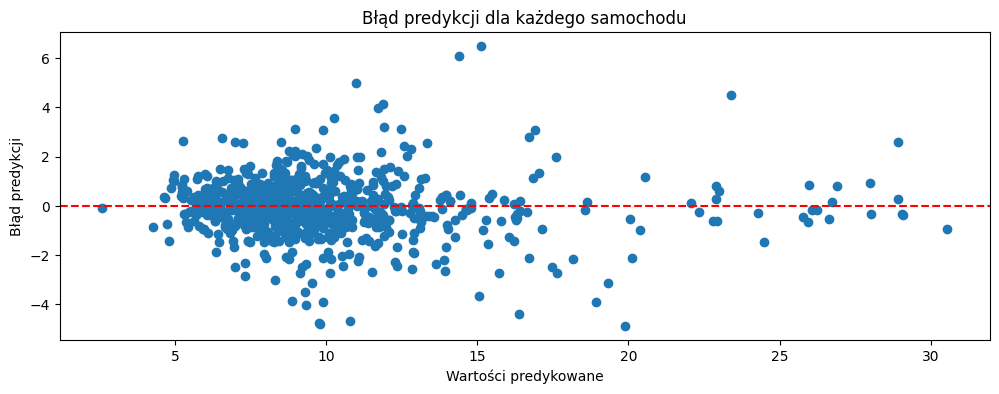

In [19]:
res_plot(*single_res)

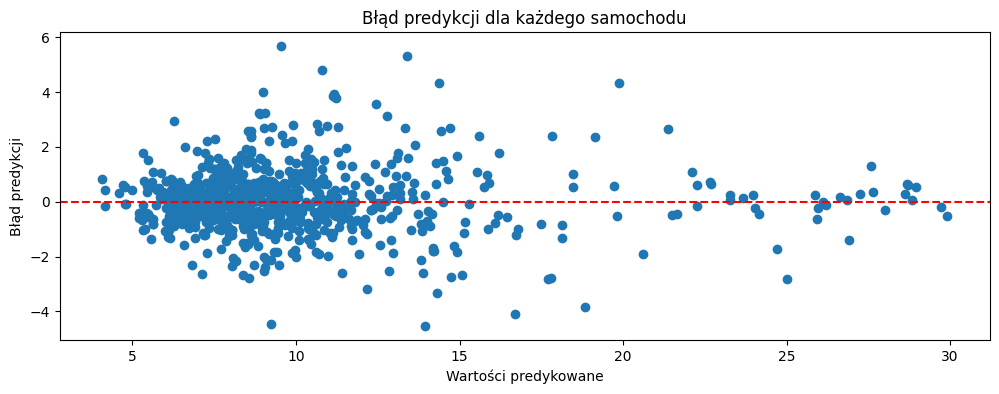

In [78]:
res_plot(*double_res)

In [20]:
metrics.mean_absolute_error(*single_res) / np.mean(single_res[0])

np.float64(0.08252193509762348)

In [21]:
metrics.mean_absolute_error(*double_res) / np.mean(double_res[0])

np.float64(0.0820274890632365)